In [1]:
import os
import itertools
import codecs
import re
import datetime
# import cairocffi as cairo
# import editdistance
import numpy as np
from scipy import ndimage
# import pylab
import matplotlib.pyplot as plt
from keras import backend as K
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Input, Dense, Activation
from keras.layers import Reshape, Lambda
from keras.layers.merge import add, concatenate
from keras.models import Model
from keras.layers.recurrent import GRU
from keras.optimizers import SGD
from keras.utils.data_utils import get_file
from keras.preprocessing import image
import keras.callbacks
import pathlib
import cv2

Using TensorFlow backend.


In [2]:
from icp_factory import GenCaptcha

gencaptcha = GenCaptcha()

class TextImageGenerator(keras.callbacks.Callback):
    # 所有可能字符
    LABELS = '0123456789abcdefghijklmnopqrstuvwxyz '
    
    def __init__(self, train_path, validate_path, img_w, img_h, channel, downsample_factor, absolute_max_string_len=6):
        """
        Args:
            train_path: 训练数据路径
            validate_path: 验证图片路径
            img_w:
            img_h:
            downsample_factor: TODO 未知
            absolute_max_string_len: 最大字符串长度
        """
        self.img_w = img_w
        self.img_h = img_h
        self.channel = channel
        self.train_path = train_path
        self.validate_path = validate_path
        self.downsample_factor = downsample_factor
        self.blank_label = self.get_output_size() - 1
        self.absolute_max_string_len = absolute_max_string_len
        # 数据
        self.train_imgs = self.get_all_imgs(self.train_path)
        self.validate_imgs = self.get_all_imgs(self.validate_path)
        self.cur_idx = 0
        
        np.random.shuffle(self.train_imgs)
        np.random.shuffle(self.validate_imgs)
    
    def get_all_imgs(self, path):
#         p = pathlib.Path(path)
        # jpg or png
#         return list([str(i) for i in p.glob('*.jpg')])
        return [os.path.join(path, i) for i in os.listdir(path)]
    
    def get_output_size(self):
        return len(self.LABELS) + 1
    
    def char2idx(self, char):
        idx = self.LABELS.find(char.lower())
        return idx if idx != -1 else self.blank_label
    
    @staticmethod
    def labels_to_text(labels):
        ret = []
        for c in labels:
            if c == len(TextImageGenerator.LABELS):  # CTC Blank
                ret.append("")
            else:
                ret.append(TextImageGenerator.LABELS[c])
        return "".join(ret)
    
    def path2matrix(self, path):
        """
        input shape: (batch_size, w, h, channel)
        """
        img = cv2.imread(path)
        img = self.formatCaptcha(img)
        return img
    
    @classmethod
    def formatCaptcha(cls, img):
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = img/ 255.
#         img_transpose = np.einsum('hw->wh', img)
        img = np.expand_dims(img, axis=-1)
        return img
    
    def _get_one_captcha(self):
        captcha, text = gencaptcha.gen_one()
        return captcha, text

    def get_next_batch(self, paths, batch_size=32):
        def get_label(img_path):
            """
            获取验证码对应的字符串
            """
            return os.path.basename(img_path).split('.')[0].lower()
        i = 0
#         X_data = np.zeros((batch_size, self.img_w, self.img_h, self.channel))
        X_data = np.zeros((batch_size, self.img_h, self.img_w, self.channel))
        labels = np.zeros((batch_size, self.absolute_max_string_len))
        input_length = np.zeros([batch_size, 1])
        label_length = np.zeros([batch_size, 1])
        source_str = []
        while i < batch_size:
            if self.cur_idx >= len(paths):
                # 归零，洗牌
                self.cur_idx = 0
                np.random.shuffle(paths)
#             img_path = paths[self.cur_idx]
#             label_text = get_label(img_path)
            # 使用自动生成的
            captcha, label_text = self._get_one_captcha()
#             X_data[i, :] = self.path2matrix(img_path)
            X_data[i, :] = self.formatCaptcha(captcha)
            input_length[i] = self.img_w // self.downsample_factor - 2
            label_length[i] = len(label_text)
            labels[i] = [self.char2idx(char) for char in label_text]
            source_str.append(label_text)
            
            self.cur_idx += 1
            i += 1
            
        inputs = {
              'the_input': X_data,
              'the_labels': labels,
              'input_length': input_length,
              'label_length': label_length,
              'source_str': source_str  # used for visualization only
        }
        outputs = {'ctc': np.zeros([batch_size])}
        return (inputs, outputs)
            
    def get_next_train(self, batch_size=32):
        while True:
            yield self.get_next_batch(self.train_imgs, batch_size)
    
    def get_next_val(self, batch_size=100):
        while True:
            yield self.get_next_batch(self.validate_imgs, batch_size)
        


# train_path = 'E:\\traindata\\captcha_create\\train'
# validate_path = 'E:\\traindata\\captcha_create\\test'
train_path = '/media/moon/0000678400004823/data/train'
validate_path = '/media/moon/0000678400004823/data/test'
# test_img = os.path.join(train_path, '00ARLO.jpg')

img_w = 200
img_h = 60
channel = 1
downsample_factor = 4
img_gen = TextImageGenerator(train_path, validate_path, img_w, img_h, channel, downsample_factor)
ret_input, ret_output = next(img_gen.get_next_train(3))
ret_input, ret_output = next(img_gen.get_next_train(3))
print(ret_input['the_input'].shape)
print(ret_input['the_input'][:3, :3, :3])
print(ret_input['the_labels'])
print(ret_input['input_length'])
print(ret_input['label_length'])
print(ret_input['source_str'])

(3, 60, 200, 1)
[[[[0.79215686]
   [0.79215686]
   [0.79215686]]

  [[0.79215686]
   [0.79215686]
   [0.79215686]]

  [[0.79215686]
   [0.79215686]
   [0.79215686]]]


 [[[0.80784314]
   [0.80784314]
   [0.80784314]]

  [[0.80784314]
   [0.80784314]
   [0.80784314]]

  [[0.80784314]
   [0.80784314]
   [0.80784314]]]


 [[[0.77254902]
   [0.77254902]
   [0.77254902]]

  [[0.77254902]
   [0.77254902]
   [0.77254902]]

  [[0.77254902]
   [0.77254902]
   [0.77254902]]]]
[[11. 12. 16.  6. 13.  8.]
 [ 9. 25.  2.  5. 34.  6.]
 [25.  3. 30. 30. 20.  9.]]
[[48.]
 [48.]
 [48.]]
[[6.]
 [6.]
 [6.]]
['bcg6d8', '9p25y6', 'p3uuk9']


In [3]:
class CustomTextImageGenerator(TextImageGenerator):
    def get_next_batch(self, paths, batch_size=32):
        def get_label(img_path):
            """
            获取验证码对应的字符串
            1538839826_hdgz.png
            """
            return os.path.basename(img_path).split('_')[-1].split('.')[0].lower()
        i = 0
#         X_data = np.zeros((batch_size, self.img_w, self.img_h, self.channel))
        X_data = np.zeros((batch_size, self.img_h, self.img_w, self.channel))
        labels = np.zeros((batch_size, self.absolute_max_string_len))
        input_length = np.zeros([batch_size, 1])
        label_length = np.zeros([batch_size, 1])
        source_str = []
        while i < batch_size:
            if self.cur_idx >= len(paths):
                # 归零，洗牌
                self.cur_idx = 0
                np.random.shuffle(paths)
            img_path = paths[self.cur_idx]
            label_text = get_label(img_path)
            # 使用自动生成的
            img = self.path2matrix(img_path)
            X_data[i, :, :img.shape[1], :] = img
#             X_data[i, :] = self.formatCaptcha(captcha)
            input_length[i] = self.img_w // self.downsample_factor - 2
            label_length[i] = len(label_text)
            labels[i][:len(label_text)] = [self.char2idx(char) for char in label_text]
            source_str.append(label_text)
            
            self.cur_idx += 1
            i += 1
            
        inputs = {
              'the_input': X_data,
              'the_labels': labels,
              'input_length': input_length,
              'label_length': label_length,
              'source_str': source_str  # used for visualization only
        }
        outputs = {'ctc': np.zeros([batch_size])}
        return (inputs, outputs)
    
train_path = '/media/moon/0000678400004823/qrcode'
validate_path = '/media/moon/0000678400004823/qrcode_test'
# test_img = os.path.join(train_path, '00ARLO.jpg')

img_w = 69
img_h = 24
channel = 1
downsample_factor = 4
img_gen = CustomTextImageGenerator(train_path, validate_path, img_w, img_h, channel, downsample_factor)
ret_input, ret_output = next(img_gen.get_next_train(3))
ret_input, ret_output = next(img_gen.get_next_train(3))
print(ret_input['the_input'].shape)
print(ret_input['the_input'][:3, :3, :3])
print(ret_input['the_labels'])
print(ret_input['input_length'])
print(ret_input['label_length'])
print(ret_input['source_str'])

(3, 24, 69, 1)
[[[[0.32941176]
   [0.32941176]
   [0.32941176]]

  [[0.32941176]
   [1.        ]
   [1.        ]]

  [[0.32941176]
   [1.        ]
   [1.        ]]]


 [[[0.32941176]
   [0.32941176]
   [0.32941176]]

  [[0.32941176]
   [1.        ]
   [1.        ]]

  [[0.32941176]
   [1.        ]
   [1.        ]]]


 [[[0.32941176]
   [0.32941176]
   [0.32941176]]

  [[0.32941176]
   [1.        ]
   [1.        ]]

  [[0.32941176]
   [1.        ]
   [1.        ]]]]
[[33. 28.  0.  0.  0.  0.]
 [26. 29. 20. 20.  0.  0.]
 [ 1.  4.  0.  0.  0.  0.]]
[[15.]
 [15.]
 [15.]]
[[2.]
 [4.]
 [2.]]
['xs', 'qtkk', '14']


In [4]:
conv_filters = 16
kernel_size = (3, 3)
pool_size = 2
time_dense_size = 32
rnn_size = 512
minibatch_size = 32
OUTPUT_DIR = 'E:\\Workplace\\bdzh\\MachineLearning\\SmallCaptcha\\image_ocr'


# the actual loss calc occurs here despite it not being
# an internal Keras loss function

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage:
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

if K.image_data_format() == 'channels_first':
    input_shape = (channel, img_w, img_h)
else:
#     input_shape = (img_w, img_h, channel)
    input_shape = (img_h, img_w, channel)

act = 'relu'
input_data = Input(name='the_input', shape=input_shape, dtype='float32')
inner = Conv2D(conv_filters, kernel_size, padding='same',
               activation=act, kernel_initializer='he_normal',
               name='conv1')(input_data)
inner = MaxPooling2D(pool_size=(pool_size, pool_size), name='max1')(inner)
inner = Conv2D(conv_filters, kernel_size, padding='same',
               activation=act, kernel_initializer='he_normal',
               name='conv2')(inner)
inner = MaxPooling2D(pool_size=(pool_size, pool_size), name='max2')(inner)

conv_to_rnn_dims = (img_w // (pool_size ** 2), (img_h // (pool_size ** 2)) * conv_filters)
inner = Reshape(target_shape=conv_to_rnn_dims, name='reshape')(inner)

# cuts down input size going into RNN:
inner = Dense(time_dense_size, activation=act, name='dense1')(inner)

# Two layers of bidirectional GRUs
# GRU seems to work as well, if not better than LSTM:
gru_1 = GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal', name='gru1')(inner)
gru_1b = GRU(rnn_size, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', name='gru1_b')(inner)
gru1_merged = add([gru_1, gru_1b])
gru_2 = GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal', name='gru2')(gru1_merged)
gru_2b = GRU(rnn_size, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', name='gru2_b')(gru1_merged)

# transforms RNN output to character activations:
inner = Dense(img_gen.get_output_size(), kernel_initializer='he_normal',
              name='dense2')(concatenate([gru_2, gru_2b]))
y_pred = Activation('softmax', name='softmax')(inner)
base_model = Model(input=input_data, output=y_pred)
base_model.summary()

labels = Input(name='the_labels', shape=[img_gen.absolute_max_string_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')
# Keras doesn't currently support loss funcs with extra parameters
# so CTC loss is implemented in a lambda layer
loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])

# clipnorm seems to speeds up convergence
sgd = SGD(lr=0.02, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5)

model = Model(inputs=[input_data, labels, input_length, label_length], outputs=loss_out)





__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          (None, 24, 69, 1)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 24, 69, 16)   160         the_input[0][0]                  
__________________________________________________________________________________________________
max1 (MaxPooling2D)             (None, 12, 34, 16)   0           conv1[0][0]                      
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 12, 34, 16)   2320        max1[0][0]                       
__________________________________________________________________________________________________
max2 (MaxP

/home/moon/.virtualenvs/bdzh/lib/python3.6/site-packages/ipykernel_launcher.py:55: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("th..., outputs=Tensor("so...)`


In [5]:

class VizCallback(keras.callbacks.Callback):

    def __init__(self, run_name, test_func, text_img_gen, num_display_words=6):
        self.test_func = test_func
        self.output_dir = os.path.join(
            OUTPUT_DIR, run_name)
        self.text_img_gen = text_img_gen
        self.num_display_words = num_display_words
        if not os.path.exists(self.output_dir):
            os.makedirs(self.output_dir)

    def show_edit_distance(self, num):
        num_left = num
        mean_norm_ed = 0.0
        mean_ed = 0.0
        while num_left > 0:
            word_batch = next(self.text_img_gen)[0]
            num_proc = min(word_batch['the_input'].shape[0], num_left)
            decoded_res = decode_batch(self.test_func, word_batch['the_input'][0:num_proc])
            for j in range(num_proc):
                edit_dist = editdistance.eval(decoded_res[j], word_batch['source_str'][j])
                mean_ed += float(edit_dist)
                mean_norm_ed += float(edit_dist) / len(word_batch['source_str'][j])
            num_left -= num_proc
        mean_norm_ed = mean_norm_ed / num
        mean_ed = mean_ed / num
        print('\nOut of %d samples:  Mean edit distance: %.3f Mean normalized edit distance: %0.3f'
              % (num, mean_ed, mean_norm_ed))

    def on_epoch_end(self, epoch, logs={}):
        if epoch % 10 == 0: # 每10个周期计算一次正确率
            word_batch = next(self.text_img_gen)[0]
            res = decode_batch(self.test_func, word_batch['the_input'])
            if word_batch['the_input'][0].shape[0] < 256:
                cols = 2
            else:
                cols = 1
            acc = 0
            total = word_batch['the_input'].shape[0]
            for i in range(total):
                if word_batch['source_str'][i].lower() == res[i].lower():
                    acc += 1
            acc_ratio = 100 * acc / total
            print('正确率: %0.5f' % acc_ratio)
            if acc_ratio > 50:
                self.model.save_weights(os.path.join(self.output_dir, 'weights%02d_acc_%0.5f.h5' % (epoch, acc_ratio)))
        word_batch = next(self.text_img_gen)[0]
        res = decode_batch(self.test_func, word_batch['the_input'][0:self.num_display_words])
        if word_batch['the_input'][0].shape[0] < 256:
            cols = 2
        else:
            cols = 1
        for i in range(self.num_display_words):
            plt.subplot(self.num_display_words // cols, cols, i + 1)
            if K.image_data_format() == 'channels_first':
                the_input = word_batch['the_input'][i, 0, :, :]
            else:
                the_input = word_batch['the_input'][i, :, :, 0]
            plt.imshow(the_input, cmap='Greys_r')
            plt.xlabel('T = \'%s\' Decoed = \'%s\'' % (word_batch['source_str'][i], res[i]))
        plt.savefig(os.path.join(self.output_dir, 'e%02d.png' % (epoch)))
        plt.close()

def decode_batch(test_func, word_batch):
    out = test_func([word_batch])[0]
    ret = []
    for j in range(out.shape[0]):
        out_best = list(np.argmax(out[j, 2:], 1))
        out_best = [k for k, g in itertools.groupby(out_best)]
        outstr = TextImageGenerator.labels_to_text(out_best)
        ret.append(outstr)
    return ret

In [7]:



def evaluate(test_func, img_gen, batch_size=5):
    correct_count = 0
    img_gen = img_gen.get_next_val(batch_size=batch_size)
    _x, _ctc = next(img_gen)
    for i in range(batch_size):
        test_X = _x['the_input'][i]
        test_c = _x['source_str'][i]
        test_X = np.expand_dims(test_X, axis=-1)
        result = decode_batch(test_func, test_X)[0]
        try:
            if test_c.lower() == result.lower():
                correct_count += 1
                # print("[INFO] actual: %s, predict: %s" % (test_c, result))
            else:
                print("[ERROR] actual: %s, predict: %s" % (test_c, result))
        except Exception as e:
            print(e.message)
    print("Accuracy: %.2f%%" % ((float(correct_count) / batch_size) * 100))
    
class Evaluator(keras.callbacks.Callback):
    def __init__(self, test_func, text_img_gen):
        self.test_func = test_func
        self.text_img_gen = text_img_gen
        
    def on_epoch_end(self, epoch, logs={}):
        evaluate(self.test_func, self.text_img_gen)



In [8]:
# the loss calc occurs elsewhere, so use a dummy lambda func for the loss
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=sgd)
# captures output of softmax so we can decode the output during visualization
test_func = K.function([input_data], [y_pred])

viz_cb = VizCallback(datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S'), test_func, img_gen.get_next_val())
# evaluate_gen = TextImageGenerator(train_path, validate_path, img_w, img_h, channel, downsample_factor)
# evaluator = Evaluator(test_func, evaluate_gen)

In [9]:
# 训练
model.fit_generator(generator=img_gen.get_next_train(100),
                    steps_per_epoch=100,
                    epochs=400,
                    validation_data=img_gen.get_next_val(1000),
                    validation_steps=5,
                    callbacks=[viz_cb],
                    verbose=1)

Epoch 1/400
100/100 [==============================] - 59s 588ms/step - loss: 12.4013 - val_loss: 10.0194
正确率: 0.00000
Epoch 2/400
100/100 [==============================] - 57s 567ms/step - loss: 8.6069 - val_loss: 6.7020
Epoch 3/400
100/100 [==============================] - 57s 570ms/step - loss: 5.2409 - val_loss: 3.9868
Epoch 4/400
100/100 [==============================] - 56s 562ms/step - loss: 2.9628 - val_loss: 2.3589
Epoch 5/400
100/100 [==============================] - 57s 572ms/step - loss: 1.6813 - val_loss: 1.5971
Epoch 6/400
100/100 [==============================] - 59s 594ms/step - loss: 0.9493 - val_loss: 1.2268
Epoch 7/400
100/100 [==============================] - 61s 610ms/step - loss: 0.4991 - val_loss: 1.0018
Epoch 8/400
100/100 [==============================] - 62s 619ms/step - loss: 0.2676 - val_loss: 0.8756
Epoch 9/400
100/100 [==============================] - 62s 620ms/step - loss: 0.1488 - val_loss: 0.8138
Epoch 10/400
100/100 [===========================

KeyboardInterrupt: 

In [ ]:
%matplotlib inline
generator = img_gen.get_next_val(2)
_x_input, _  = next(generator)
_X_test = _x_input['the_input']
_y_test = _x_input['the_labels']

img = _X_test[0]
print(img.shape)
print(np.einsum('hwc->whc', img).shape)
print(img[:, :, 0].T.shape)
print(np.max(img.flatten()))
print(np.min(img.flatten()))
print(_X_test[0].flatten().shape)
plt.subplot(1, 2, 1)
plt.imshow(img[:, :, 0].T)
plt.subplot(1, 2, 2)
img = np.einsum('hwc->whc', img)
plt.imshow(img)
plt.show()

# for i in range(_y_pred.shape[0]):
#     _y_pred = base_model.predict(np.expand_dims(_X_test[i], axis=0))[:, 2:, :]
#     print(_y_pred.shape)
#     for i in range(_y_pred.shape[0]):
#         __X_test = _X_test[i]
#         __y_test = _y_test[i]
#         __y_pred = _y_pred[i]
#         __y_pred = np.expand_dims(__y_pred, axis=0)
#         shape = __y_pred.shape
#         ctc_decode = K.ctc_decode(__y_pred, 
#                                   input_length=np.ones(shape[0])*shape[1])[0][0]
#         out = K.get_value(ctc_decode)[0]
#         print(out)


In [ ]:

from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)
from IPython.display import Image
Image(filename='model.png')

In [ ]:
model.save_weights('./weights/my_model_weights.h5')

In [ ]:
import os
train_path = 'E:\\traindata\\captcha_create\\train'
validate_path = 'E:\\traindata\\captcha_create\\test'
test_img = os.path.join(train_path, '00ARLO.jpg')

img_w = 200
img_h = 60
channel = 3
downsample_factor = 4
gen = TextImageGenerator(train_path, validate_path, img_w, img_h, channel, downsample_factor)
for i in range(40):
    next(gen.get_next_train(500))

imgs = next(gen.get_next_train(2))
_x, _ctc = imgs[0], imgs[1]

_the_input = _x['the_input']
_the_labels = _x['the_labels']
_input_length = _x['input_length']
_label_length = _x['label_length']
print(_ctc)
num = _the_input.shape[0]

for i in range(num):
    img = _the_input[i]
    print(img.shape)
    plt.subplot(1, num, i + 1)
    plt.xlabel('label: %s' % _the_labels[i])
    plt.imshow(img[:, :, 0], cmap='Greys_r')
    


In [ ]:
model.save_weights('E:\\Workplace\\bdzh\\MachineLearning\\SmallCaptcha\\image_ocr\\2019_05_23_23_32_26\\weights400.h5')

In [ ]:
import math
import requests
from user_agent import generate_user_agent
from random import randint
from PIL import Image
from io import BytesIO
# from models import predict_images
import numpy as np
from string import digits, ascii_lowercase
# import dataset
import cv2

CHAPTER_LIST = digits + ascii_lowercase

CHAPTER_LIST = CHAPTER_LIST.replace('0', '').replace('1', '').replace('2', '')


class IcpMemoInfoClient(object):
    TIMEOUT = 10
    MAX_ERROR_COUNT = 10
    # CHAPTER_LIST = digits + ascii_lowercase
    HOST = 'beian.miit.gov.cn'

    def __init__(self):
        self.sess = requests.Session()
        # 初始化session
        self._init_sess()

    def _init_sess(self):
        headers = {
            'User-Agent': generate_user_agent()
        }
        self.sess.headers = headers

    def _request(self, method, uri, **kwargs):
        if method.lower() == 'post':
            request_method = self.sess.post
        else:
            request_method = self.sess.get
        return request_method('http://%s/%s' % (self.HOST, uri), timeout=self.TIMEOUT, **kwargs)

    def _split_image(self, img, num=6):
        """
        分割图片
        Args:
            img: 
            num: 6
        Returns:

        """
        height, width = img.shape
        d = math.ceil(width / num)
        croped_images = []
        for i in range(num):
            start, end = i * d, (i + 1) * d
            if end > width:
                start, end = width - d, width
            img_croped = img[:, start: end]
            croped_images.append(np.copy(img_croped))
        return croped_images

    def _predict_images(self, images):
        """
        预测单一的字符的图片的列表
        Args:
            img: 

        Returns:

        """
        # 利用模型预测
        # 转化为np array
        # images_array = np.array([self._image2matrix(img) for img in images])
        idxs = predict_images(images)
        # idx2char
        ret = ''.join([self._idx2char(i) for i in idxs])
        return ret

    def _idx2char(self, idx):
        return CHAPTER_LIST[idx]

    def _image2matrix(self, image):
        # array = np.array(image.getdata())
        image.resize((image.shape[0], image.shape[1], 1))
        return image

    def _prepare_captcha(self, image):
        """
        预处理图片
        """
        # 转化为黑白
        # image = image.convert('LA')
        # TODO 降噪
        # gray_src = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # gray_src = cv2.bitwise_not(gray_src)
        #
        # # 二值化
        # binary_src = cv2.adaptiveThreshold(gray_src, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 15, -2)
        # # 提取水平线    src.shape[1]得到src列数
        # # hline = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 1), (-1, -1))
        #
        # hline = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 4), (-1, -1))  # 定义结构元素，卷积核
        # # print('hline: %s' % hline)
        # # 提取垂直线    src.shape[0]得到src行数
        # vline = cv2.getStructuringElement(cv2.MORPH_RECT, (4, 1), (-1, -1))
        # # vline = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
        # # 这两步就是形态学的开操作——先腐蚀再膨胀
        # # temp = cv2.erode(binary_src, hline)     #腐蚀
        # # dst = cv2.dilate(temp, hline)           #膨胀
        # # 开运算
        # dst = cv2.morphologyEx(binary_src, cv2.MORPH_OPEN, hline)  # 水平方向
        # dst = cv2.morphologyEx(dst, cv2.MORPH_OPEN, vline)  # 垂直方向
        # # 将二指图片的效果反转既黑色变白色，白色变黑色。 非操作
        # dst = cv2.bitwise_not(dst)
        image = dataset._denoise(image)
        imgs_splited = dataset._split_image(image, size=(32, 32))
        # 转化为rgb channel 3
        outputs = [cv2.cvtColor(img, cv2.COLOR_GRAY2RGB) for img in imgs_splited]
        return outputs

    def predict_captcha(self, images):
        """
        预测验证码
        Args:
            image: 

        Returns:

        """
        # TODO
        # images = self._split_image(image)
        return self._predict_images(images)

    def get_captcha(self):
        """
        获取验证码
        Returns:

        """
        url = 'getVerifyCode?%d' % randint(0, 100)
        return self._request('get', url).content

    def verify_code(self, code):
        url = 'common/validate/validCode.action'
        data = {
            'validateValue': code
        }
        ret = None
        try:
            ret = self._request('post', url, data=data)
            result = ret.json()['result']
        except Exception as e:
            print(e)
            if ret:
                print(ret.text)
            result = False
        return result

    def process_captcha(self):
        # 获取验证码
        captcha_bytes = self.get_captcha()
        # 处理验证码
        captcha_io = BytesIO(captcha_bytes)
        # captcha = Image.open(captcha_io)
        captcha_io.seek(0)
        captcha_bytes = np.asarray(bytearray(captcha_io.read()), dtype=np.uint8)
        captcha = cv2.imdecode(captcha_bytes, cv2.IMREAD_COLOR)
        captcha = self._prepare_captcha(captcha)
        # 分析验证码
        captcha_text = self.predict_captcha(captcha)
        # 验证验证码
        ret = self.verify_code(captcha_text)
        return ret, captcha_text, captcha

    def search(self, **kwargs):
        """
        
        Args:
            **kwargs: 
                data = {
                    'siteName': '',
                    'condition': 1,
                    'siteDomain': '',
                    'siteUrl': '',
                    'mainLicense': '',
                    'siteIp': '',
                    'unitName': '',
                    'mainUnitNature': -1,
                    'certType': -1,
                    'mainUnitCertNo': '',
                    'verifyCode': captcha_text
                }
        Returns:

        """
        url = 'http://www.miitbeian.gov.cn/icp/publish/query/icpMemoInfo_searchExecute.action'
        err_count = 0
        while err_count < self.MAX_ERROR_COUNT:
            is_captcha_validate, captcha_text = self.process_captcha()
            if is_captcha_validate:
                break
        if not is_captcha_validate:
            raise Exception('验证码验证失败: %s' % captcha_text)
        data = {
            'siteName': '',
            'condition': 1,
            'siteDomain': '',
            'siteUrl': '',
            'mainLicense': '',
            'siteIp': '',
            'unitName': '',
            'mainUnitNature': -1,
            'certType': -1,
            'mainUnitCertNo': '',
            'verifyCode': captcha_text
        }
        ret = self._request('post', url, data=data)
        # TODO 处理html
        return ret
    
client = IcpMemoInfoClient()
captcha_bytes = client.get_captcha()
# 处理验证码
captcha_io = BytesIO(captcha_bytes)
# captcha = Image.open(captcha_io)
captcha_io.seek(0)
captcha_bytes = np.asarray(bytearray(captcha_io.read()), dtype=np.uint8)
captcha_icp = cv2.imdecode(captcha_bytes, cv2.IMREAD_COLOR)
captcha, text = gencaptcha.gen_one()

plt.subplot(2, 1, 1)
plt.imshow(captcha, cmap='Greys_r')
plt.subplot(2, 1, 2)
plt.imshow(captcha_icp, cmap='Greys_r')

model.load_weights('./weights/weights400.h5')
# 格式化图片
captcha = TextImageGenerator.formatCaptcha(captcha)
captcha = np.expand_dims(captcha, axis=0)
ret = decode_batch(test_func, captcha)
print('预测自动生成的: %s' % ret)


captcha_icp = TextImageGenerator.formatCaptcha(captcha_icp)
captcha_icp = np.expand_dims(captcha_icp, axis=0)
ret = decode_batch(test_func, captcha_icp)
print('预测icp: %s' % ret)

(1, 24, 52, 1)
预测: ['pd7']


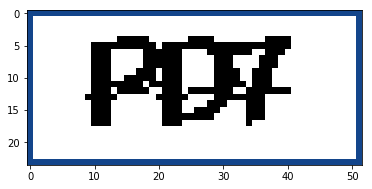

In [29]:
import requests
from PIL import Image
from io import BytesIO

path = '/home/moon/test.png'
captcha = cv2.imread(path)

plt.imshow(captcha)
img_w = 69
img_h = 24
x = np.zeros((1, img_h, img_w, 1))
captcha = TextImageGenerator.formatCaptcha(captcha)
captcha = np.expand_dims(captcha, axis=0)
print(captcha.shape)
x[0, :, :captcha.shape[2], :] = captcha
ret = decode_batch(test_func, x)
print('预测: %s' % ret)